# Importing necessary libraries

### Group Members:

1. Akshay Padte - 1711036
2. Girish Thatte - 1711059
3. Abdeali Arsiwala - 1711064
4. Kaustubh Damania - 1711071
5. Arghyadeep Das - 1711072
6. Mihir Gada - 1711076

In [56]:
import numpy as np # numeric computations
import pandas as pd # data processing
import matplotlib.pyplot as plt # plotting graphs
import warnings # warnings
plt.style.use('seaborn') # Chaning the plot style
warnings.filterwarnings("ignore") # to ignore any warnings
import os
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [57]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/akshay/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Loading the dataset

In [58]:
# Loading the IMDB dataset into pandas dataframe
df_movies = pd.read_csv('./dataset/movies.csv') # reading movies.csv file
df_ratings = pd.read_csv('./dataset/ratings.csv') # reading ratings.csv file

# Exploratory Data Analysis (EDA)

EDA involves looking at and describing the data set from various angles and then summarizing it. It is helpful in analyzing the distribution and statistics of our data.

In [59]:
# shape attribute tells us a number of tuples and feature variables in our dataset
print("Shape of df_movies: ", df_movies.shape)
print("Shape of df_ratings: ", df_ratings.shape)

Shape of df_movies:  (10329, 3)
Shape of df_ratings:  (105339, 4)


In [60]:
# print top 10 rows of dataframe - movies
df_movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [61]:
# print top 10 rows of dataframe - ratings
df_ratings.head(10)

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523
5,1,110,4.0,1217896150
6,1,150,3.0,1217895940
7,1,161,4.0,1217897864
8,1,165,3.0,1217897135
9,1,204,0.5,1217895786


So, rating dataset has
1. userId - unique for each user
2. movieId - we can take the title of the movie from movies dataset
3. rating - Ratings given by each user to all the movies

In [62]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
movieId    10329 non-null int64
title      10329 non-null object
genres     10329 non-null object
dtypes: int64(1), object(2)
memory usage: 242.2+ KB


In [63]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
userId       105339 non-null int64
movieId      105339 non-null int64
rating       105339 non-null float64
timestamp    105339 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.2 MB


In [64]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,105339.000000,105339.000000,105339.000000,1.053390e+05
mean,364.924539,13381.312477,3.516850,1.130424e+09
std,197.486905,26170.456869,1.044872,1.802660e+08
min,1.000000,1.000000,0.500000,8.285650e+08
25%,192.000000,1073.000000,3.000000,9.711008e+08
50%,383.000000,2497.000000,3.500000,1.115154e+09
75%,557.000000,5991.000000,4.000000,1.275496e+09
max,668.000000,149532.000000,5.000000,1.452405e+09


In [65]:
# getting the number of movies under each genre
genrewise_movies_count = {}
for genres in df_movies["genres"]:
    for genre in genres.split("|"):
        genrewise_movies_count[genre] = genrewise_movies_count.get(genre, 0) + 1

print("Number of unique genres: ", len(list(genrewise_movies_count)))
genrewise_movies_count

Number of unique genres:  20


{'Adventure': 1164,
 'Animation': 401,
 'Children': 540,
 'Comedy': 3515,
 'Fantasy': 670,
 'Romance': 1788,
 'Drama': 5220,
 'Action': 1737,
 'Crime': 1440,
 'Thriller': 2187,
 'Horror': 1001,
 'Mystery': 675,
 'Sci-Fi': 860,
 'IMAX': 152,
 'War': 503,
 'Musical': 409,
 'Documentary': 415,
 'Western': 235,
 'Film-Noir': 195,
 '(no genres listed)': 7}

In [66]:
g = df_ratings.groupby('userId')['rating'].count()
topUsers = g.sort_values(ascending=False)[:15]
g = df_ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending=False)[:15]
top_r = df_ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,457,480,527,589,593,1196,1198,2571
userId,,,,,,,,,,,,,,,
62,2.0,3.0,3.0,2.5,5.0,4.5,4.0,1.0,3.0,5.0,4.0,4.5,3.0,1.0,1.5
63,NaN,4.5,3.0,4.5,3.5,4.0,4.5,3.0,3.0,NaN,3.5,3.5,5.0,4.0,5.0
128,3.0,5.0,4.5,3.5,5.0,5.0,4.5,4.0,3.5,3.5,3.5,4.0,4.0,4.0,4.0
224,4.5,5.0,4.0,3.5,4.5,5.0,5.0,4.0,4.5,4.0,4.5,4.0,4.5,4.0,4.5
232,3.5,NaN,4.0,4.0,4.5,4.0,4.0,4.5,3.5,NaN,4.5,4.0,4.0,5.0,4.5
310,3.0,4.0,4.0,3.0,4.0,4.5,3.5,4.0,3.0,4.0,4.5,3.5,3.5,3.0,4.0
413,4.0,2.5,NaN,4.0,4.5,5.0,4.0,NaN,5.0,4.0,4.0,3.5,4.0,4.0,5.0
451,3.5,4.5,4.0,4.5,4.5,4.0,NaN,4.0,4.0,NaN,4.0,5.0,4.0,4.5,3.5
458,3.5,5.0,5.0,4.5,5.0,4.0,4.0,4.0,2.0,5.0,5.0,5.0,4.5,5.0,5.0


## Data Visualisation

### Barplot of Genre-wise movies

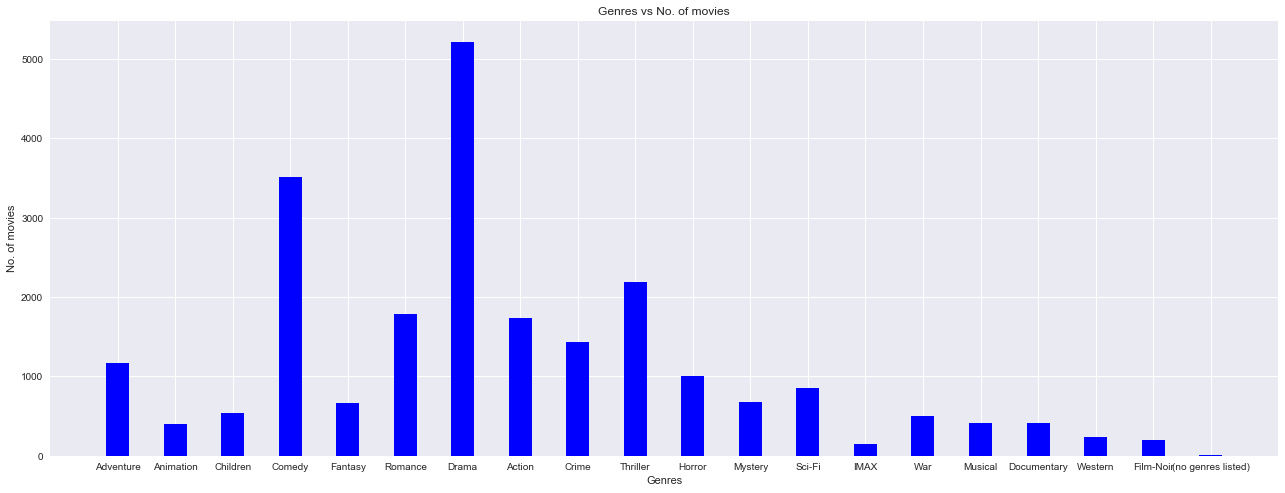

In [67]:
# Barplot of Genres vs No. of movies
genres = list(genrewise_movies_count.keys())
counts = list(genrewise_movies_count.values())

fig = plt.figure(figsize = (22, 8))
 
# creating the bar plot
plt.bar(genres, counts, color ='blue', width = 0.4) 
plt.xlabel("Genres")
plt.ylabel("No. of movies")
plt.title("Genres vs No. of movies")
plt.show()

Analysis : A large number of movies come under Drama and Comedy genre. Some movies are not listed in any genre.

### Scatter plot for MovieId vs Number of users voted

In [68]:
number_of_users_voted = df_ratings.groupby('movieId')['rating'].agg('count')
number_of_movies_voted = df_ratings.groupby('userId')['rating'].agg('count')

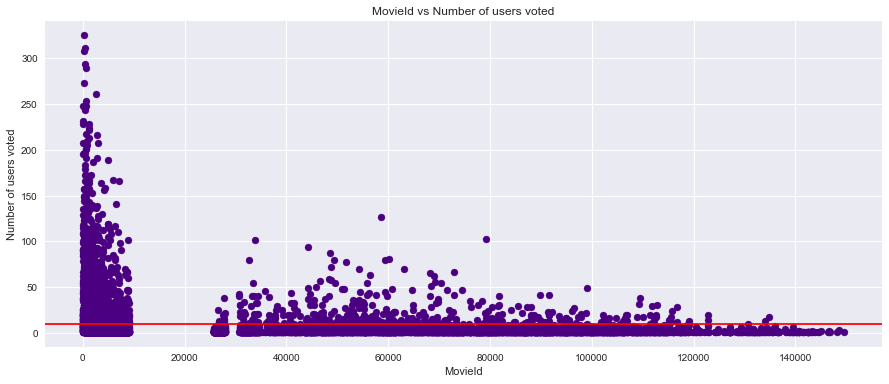

In [69]:
fig = plt.figure(figsize = (15, 6))
plt.scatter(number_of_users_voted.index, number_of_users_voted, color='indigo')
plt.axhline(y = 10, color = 'r')
plt.xlabel('MovieId')
plt.ylabel('Number of users voted')
plt.title('MovieId vs Number of users voted')
plt.show()

**Analysis : Movies with MovieId 0 to 500 are being voted by more number of user**

In [70]:
# Merge both the datasets
df = pd.merge(df_movies, df_ratings, on = 'movieId')
print(df.shape)
df.head(10)

(105339, 6)


,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,5.0,859046895
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,1303501039
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,5.0,858610933
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.0,850815810
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,14,4.0,851766286
5,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,5.0,1350206819
6,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,28,3.0,884098350
7,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,29,4.0,846942580
8,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,30,4.5,1292690069
9,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,31,4.0,832397496


In [71]:
import re
def find_year(row):
    year = re.search('(\d\d\d\d)', row)
    if year is None:
        print(row)
        return None
    return year.group().strip()

find_year("Hello there, welcome to (2020) of (20201) here")

'2020'

In [72]:
df['year'] = df['title'].apply(find_year)
df['year'].head()

Li'l Quinquin (    )
Elämältä kaiken sain (    )


0    1995
1    1995
2    1995
3    1995
4    1995
Name: year, dtype: object

In [73]:
df.title = df.title.apply(lambda x: (x.strip())[:-7])

In [74]:
df.drop(['timestamp'], axis=1, inplace=True)

In [75]:
df.head(10)

,movieId,title,genres,userId,rating,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,2,5.0,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,8,5.0,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,11,4.0,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,14,4.0,1995
5,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,17,5.0,1995
6,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,28,3.0,1995
7,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,29,4.0,1995
8,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,30,4.5,1995
9,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,31,4.0,1995


In [76]:
# Groupby all movie titles together and find their mean ratings
# average rating of each movie.
df.groupby('title')['rating'].mean().head()

title
'71                                 3.500
'Hellboy': The Seeds of Creation    3.000
'Round Midnight                     2.500
'Til There Was You                  4.000
'burbs, The                         3.125
Name: rating, dtype: float64

The average ratings are not sorted. Sort the ratings in the descending order of their average ratings.

In [77]:
# Sort movies based on ratings from highest to lowest
df.groupby('title')['rating'].mean().sort_values(ascending = False)

title
Wings                                                                      5.0
Irony of Fate, or Enjoy Your Bath! (Ironiya sudby, ili S legkim parom!)    5.0
Flesh and the Devil                                                        5.0
Shy People                                                                 5.0
The Liberator                                                              5.0
                                                                          ... 
Who's Your Caddy?                                                          0.5
Leprechaun 2                                                               0.5
P.S. Your Cat is Dead                                                      0.5
Dark Days                                                                  0.5
Hercules in New York                                                       0.5
Name: rating, Length: 10007, dtype: float64

A movie can make it to the top of the  list even if only a single user has given it five stars rating. Thus, above stats can be misleading. Usually, a movie which is really a good one will receive a higher rating by a large number of users. So, we will look at the total number of ratings for movie.

In [78]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Pulp Fiction                 325
Forrest Gump                 311
Shawshank Redemption, The    308
Jurassic Park                294
Silence of the Lambs, The    290
Name: rating, dtype: int64

Now we can see some really good movies at the top. The above list supports our point that good movies normally receive higher ratings. Now we know that both the average rating per movie and the number of ratings per movie are important attributes. Let's create a new dataframe that contains both of these attributes.

## What is movie rating and how many users voted for this ?

In [79]:
# create a dataframe
data = pd.DataFrame(df.groupby('title')['rating'].mean())
data['rating_counts'] = pd.DataFrame(df['title'].value_counts())
data.sort_values(by=['rating_counts', 'rating'],ascending=False).head()

,rating,rating_counts
title,,
Pulp Fiction,4.160000,325
Forrest Gump,4.138264,311
"Shawshank Redemption, The",4.454545,308
Jurassic Park,3.659864,294
"Silence of the Lambs, The",4.194828,290


## Exploring different types of Recommender Systems

### 1. Content-based recommender system using cosine similarity 

In [80]:
lemmatizer = WordNetLemmatizer()
genres = df_movies["genres"]
lemmatized = []
for i in range(len(genres)):
    temp = genres[i].lower()
    temp = temp.split("|")
    temp = [lemmatizer.lemmatize(word) for word in temp]
    lemmatized.append(" ".join(temp))

In [81]:
movies_dataset = pd.DataFrame(lemmatized, columns=["genres"], index=df_movies["title"])
movies_dataset

,genres
title,
Toy Story (1995),adventure animation child comedy fantasy
Jumanji (1995),adventure child fantasy
Grumpier Old Men (1995),comedy romance
Waiting to Exhale (1995),comedy drama romance
Father of the Bride Part II (1995),comedy
...,...
Cosmic Scrat-tastrophe (2015),animation child comedy
Le Grand Restaurant (1966),comedy
A Very Murray Christmas (2015),comedy


In [82]:
cv = CountVectorizer()
genre_cv = cv.fit_transform(movies_dataset["genres"]).toarray()
genre_cv

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [83]:
print("Genres coresponding to the count vector are :\n",cv.get_feature_names())

Genres coresponding to the count vector are :
 ['action', 'adventure', 'animation', 'child', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres', 'horror', 'imax', 'listed', 'musical', 'mystery', 'no', 'noir', 'romance', 'sci', 'thriller', 'war', 'western']


In [84]:
genre_dataset = df_movies[['movieId', 'title']]
genre_dataset = genre_dataset.join(pd.DataFrame(genre_cv))
genre_dataset.head(-10)

,movieId,title,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10314,143031,Jump In! (2007),0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
10315,143257,Ashby (2015),0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10316,143385,Bridge of Spies (2015),0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
10317,143709,The Take (2009),0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [85]:
similarities = cosine_similarity(genre_cv) 

In [86]:
similarities.shape

(10329, 10329)

In [87]:
user_id = 2 #For user 18 lets recommend movies based on his recent watched movie
timestamp = df_ratings.loc[df_ratings["userId"] == user_id]
latest_movieId_watched_by_user = timestamp.sort_values(by="timestamp",ascending=False)["movieId"].values[0]
latest_movieId_watched_by_user

1356

In [88]:
movie_index = df_movies.loc[df_movies['movieId'] == latest_movieId_watched_by_user,["title"]].index[0]
genre_dataset.loc[genre_dataset['movieId'] == 1356,:]

,movieId,title,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
1102,1356,Star Trek: First Contact (1996),1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [89]:
movie_index = df_movies.loc[df_movies['movieId'] == latest_movieId_watched_by_user,["title"]].index[0]
similarity_values = pd.Series(similarities[movie_index])
similarity_values.sort_values(ascending=False)

similar_movie_indexes = list(similarity_values.sort_values(ascending=False).index)
similar_movie_indexes.remove(movie_index)

In [90]:
similarity_values_list = list(similarity_values.sort_values(ascending=False))

In [91]:
def get_movie_by_index(idx):
    return movies_dataset.index[idx]

def get_movie_by_id(movie_id):
    return df_movies.loc[df_movies['movieId'] == movie_id,['title']].values[0][0]

In [92]:
get_movie_by_index(1102)

'Star Trek: First Contact (1996)'

In [93]:
get_movie_by_id(1356)

'Star Trek: First Contact (1996)'

In [95]:
uid = int(input("Enter your User ID: "))
no_of_recs = int(input("Enter number of movie recommendations you want: "))
timestamp = df_ratings.loc[df_ratings["userId"] == uid]
latest_movieId_watched_by_user = timestamp.sort_values(by="timestamp",ascending=False)["movieId"].values[0]

movie_index = df_movies.loc[df_movies['movieId'] == latest_movieId_watched_by_user,["title"]].index[0]
similarity_values = pd.Series(similarities[movie_index])
similar_movie_indexes = list(similarity_values.sort_values(ascending=False).index)
similar_movie_indexes.remove(movie_index)
similarity_values_list = list(similarity_values.sort_values(ascending=False))
similarity_values_list.remove(0)

print("The latest movie watched by you is: ", get_movie_by_id(latest_movieId_watched_by_user))
print("\nBased on your latest movie watched, here are top 10 recommendations we think you may like: ")
for i in range(no_of_recs):
    print(f'{i+1}. {get_movie_by_index(similar_movie_indexes[i])}, Similarity: {similarity_values_list[i]}')

Enter your User ID: 5
Enter number of movie recommendations you want: 10
The latest movie watched by you is:  Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996)

Based on your latest movie watched, here are top 10 recommendations we think you may like: 
1. Horrible Bosses (2011), Similarity: 0.9999999999999998
2. See No Evil, Hear No Evil (1989), Similarity: 0.9999999999999998
3. Some Like It Hot (1959), Similarity: 0.9999999999999998
4. Ocean's Eleven (a.k.a. Ocean's 11) (1960), Similarity: 0.9999999999999998
5. Identity Thief (2013), Similarity: 0.9999999999999998
6. Horrible Bosses 2 (2014), Similarity: 0.9999999999999998
7. Scorched (2003), Similarity: 0.9999999999999998
8. Godson, The (1998), Similarity: 0.9999999999999998
9. Welcome to Collinwood (2002), Similarity: 0.9999999999999998
10. Take the Money and Run (1969), Similarity: 0.9999999999999998


#### Thus, we recommend films to a user based on genres of latest movie seen by the user and generate top N recommendations. We made use of cosine similarity to find similar movies based on genre.

### 2. Movie recommender system based on collaborative filtering using KNN

In [96]:
df = df_movies.merge(df_ratings)
users_dataset = df.loc[:,["userId","movieId","title","genres","rating"]]
df_ratings = users_dataset.loc[:,["title","rating"]].groupby("title").mean()
genres = users_dataset["genres"]

In [97]:
lemmatizer = WordNetLemmatizer()
lemmatized = []
for i in range(len(genres)):
    temp = genres[i].split("|")
    for j in range(len(temp)):
        temp[j] = lemmatizer.lemmatize(temp[j])
    lemmatized.append(" ".join(temp))

In [98]:
cv = CountVectorizer()

genre_cv = cv.fit_transform(lemmatized).toarray()

genres = pd.DataFrame(genre_cv,columns=cv.get_feature_names())
users_dataset = users_dataset.iloc[:,:-2]
users_dataset = users_dataset.join(genres)

In [99]:
users_dataset

,userId,movieId,title,action,adventure,animation,children,comedy,crime,documentary,...,listed,musical,mystery,no,noir,romance,sci,thriller,war,western
0,2,1,Toy Story (1995),0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,1,Toy Story (1995),0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8,1,Toy Story (1995),0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11,1,Toy Story (1995),0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14,1,Toy Story (1995),0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105334,475,148238,A Very Murray Christmas (2015),0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
105335,458,148626,The Big Short (2015),0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105336,576,148626,The Big Short (2015),0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105337,668,148626,The Big Short (2015),0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
final_dataset = users_dataset.drop(['movieId', 'title'], axis=1)
genre_wise_count = final_dataset.groupby("userId").sum()
ratings = df_ratings.copy()
ratings = ratings.reset_index()
genre_wise_count

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,fi,...,listed,musical,mystery,no,noir,romance,sci,thriller,war,western
userId,,,,,,,,,,,,,,,,,,,,,
1,46,31,2,3,31,31,1,45,8,25,...,0,1,13,0,2,16,25,43,10,1
2,9,10,2,3,11,3,0,11,4,5,...,0,2,2,0,0,8,5,12,0,0
3,13,9,2,5,35,12,1,36,5,3,...,0,3,4,0,0,22,3,21,3,3
4,14,17,4,6,46,18,0,76,8,3,...,0,6,10,0,6,37,3,18,16,5
5,17,22,21,21,45,6,0,19,16,6,...,0,11,3,0,0,21,6,11,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,36,30,2,3,26,9,1,16,8,22,...,0,6,5,0,0,20,22,22,7,0
665,73,51,7,16,60,61,0,128,25,25,...,0,5,24,0,0,31,25,102,17,5
666,34,27,10,19,83,36,1,101,19,30,...,0,2,20,0,7,26,30,51,8,4


In [101]:
from sklearn.neighbors import NearestNeighbors

X = genre_wise_count.iloc[:,:].values
classifier = NearestNeighbors()
classifier.fit(X)

NearestNeighbors()

In [102]:
user_id = int(input("Enter your User ID: "))
no_of_recs = int(input("Enter number of movie recommendations you want: "))

neighbors = classifier.kneighbors([X[user_id-1]],n_neighbors=10,return_distance=False)
current_user = users_dataset.loc[users_dataset["userId"] == neighbors[0][0],:]["title"].values
similar_user = users_dataset.loc[users_dataset["userId"] == neighbors[0][1],:]["title"].values

movies_list = [movie for movie in similar_user if movie not in current_user]

ratings_list = [ratings.loc[ratings.title == movie, : ]['rating'].values for movie in movies_list]
ratings_list = [float(rating) for rating in ratings_list]
movie_rating = [(movie, rating) for movie, rating in zip(movies_list, ratings_list)]
movie_rating.sort(reverse=True, key = lambda x: x[1]) 

print("Recommended Movies are: ")
for i in range(no_of_recs):
    print(f"{i+1}. {movie_rating[i][0]}, Average Rating: {movie_rating[i][1]}")

Enter your User ID: 5
Enter number of movie recommendations you want: 20
Recommended Movies are: 
1. Usual Suspects, The (1995), Average Rating: 4.328947368421052
2. North by Northwest (1959), Average Rating: 4.273972602739726
3. Lone Star (1996), Average Rating: 4.171428571428572
4. Forrest Gump (1994), Average Rating: 4.138263665594855
5. Braveheart (1995), Average Rating: 4.108870967741935
6. Hoop Dreams (1994), Average Rating: 4.083333333333333
7. Red Rock West (1992), Average Rating: 4.0
8. Ballad of Narayama, The (Narayama Bushiko) (1958), Average Rating: 4.0
9. Remains of the Day, The (1993), Average Rating: 3.9782608695652173
10. Apollo 13 (1995), Average Rating: 3.969543147208122
11. Terminator 2: Judgment Day (1991), Average Rating: 3.960474308300395
12. Much Ado About Nothing (1993), Average Rating: 3.9402985074626864
13. Fugitive, The (1993), Average Rating: 3.930327868852459
14. Sense and Sensibility (1995), Average Rating: 3.93
15. Mr. Holland's Opus (1995), Average Ratin

#### Hence, we tried collaborative filtering using K-Nearest Neighbours (KNNs) and made a recommender system based on it. This allows users to get suggestion on contents from similar users and the recommendations are ranked on average user rating of the movie.

### user-user collab filtering w/ movie rating as features and pearson's coeff similarity 

In [103]:
def get_recommendations_collab():
    data_path = 'dataset/'
    movies_filename = 'movies.csv'
    ratings_filename = 'ratings.csv'

    df_ratings = pd.read_csv(
        os.path.join(data_path, ratings_filename),
        usecols=['userId', 'movieId', 'rating'],
        dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'}
    )

    df_movies = pd.read_csv(
        os.path.join(data_path, movies_filename),
        usecols=['movieId', 'title'],
        dtype={'movieId': 'int32', 'title': 'str'})

    # df_ratings=df_ratings[:2000000]
    movie_features = df_ratings.pivot(
        index='userId',
        columns='movieId',
        values='rating'
    ).fillna(0).to_numpy()

    user_id = int(input("Enter your User ID: "))
    no_of_recs = int(input("Enter number of movie recommendations you want: "))

    user_id -= 1

    similarities = []
    for i in range(movie_features.shape[0]):
        similarities.append((np.corrcoef(movie_features[user_id], movie_features[i])[0, 1], i))

    similarities.sort(reverse=True)
    #print(similarities)
    denom = sum([e[0] for e in similarities])

    #ratings_user =  df_movie_features.iloc[user_id].copy()
    new_ratings = []
    for i in range(movie_features[user_id].shape[0]):
        if not movie_features[user_id][i] > 1e-8:
            num = 0
            # print(i)
            for y in similarities:
                num += y[0]*movie_features[y[1]][i]

            new_ratings.append((num / denom, i))

    new_ratings.sort(reverse=True)

    print('\nRecommendations for you:')
    for e in new_ratings[:no_of_recs]:
        print(df_movies.iloc[e[1]]['title'])
get_recommendations_collab()

Enter your User ID: 1
Enter number of movie recommendations you want: 20

Recommendations for you:
Toy Story (1995)
Indiana Jones and the Last Crusade (1989)
Princess Bride, The (1987)
Terminator, The (1984)
Aliens (1986)
Die Hard (1988)
Memento (2000)
Blade Runner (1982)
Alien (1979)
Lion King, The (1994)
Aladdin (1992)
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)
Good Will Hunting (1997)
One Flew Over the Cuckoo's Nest (1975)
E.T. the Extra-Terrestrial (1982)
Rock, The (1996)
Fifth Element, The (1997)
Miss Pettigrew Lives for a Day (2008)
Pirates of the Caribbean: The Curse of the Black Pearl (2003)
Ferris Bueller's Day Off (1986)


# Collaborative filtering using SVD

In [50]:
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [104]:
import pandas as pd
import numpy as np

data_path = 'dataset/'
movies_filename = 'movies.csv'
ratings_filename = 'ratings.csv'

df_movies = pd.read_csv(
    os.path.join(data_path, movies_filename),
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv(
    os.path.join(data_path, ratings_filename),
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'}
)

# df_ratings=df_ratings[:2000000]
df_movie_features = df_ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

R = df_movie_features.values
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

from scipy.sparse.linalg import svds
# from scipy.linalg import svd

U, sigma, Vt = svds(R_demeaned)

# that the Sigma$ returned is just the values instead of a diagonal matrix. 
# This is useful, but since I'm going to leverage matrix multiplication to get predictions 
# I'll convert it to the diagonal matrix form.

sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = df_movie_features.columns)
preds_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,144482,144656,144976,146344,146656,146684,146878,148238,148626,149532
0,2.305107,0.857048,0.037678,0.013452,0.127678,0.780788,0.075311,0.008663,-0.041197,1.067317,...,0.018374,-0.007095,-0.058366,-0.007411,0.027741,0.004716,0.000010,-0.007201,-0.077135,-0.006990
1,0.406786,0.223229,0.148833,0.056611,0.147981,0.309786,0.185786,0.019233,0.069146,0.464008,...,-0.002914,0.001109,-0.001079,0.001225,-0.004579,-0.001534,-0.000441,0.001148,-0.003680,0.001070
2,1.245131,0.831510,0.530275,0.194979,0.593243,1.095008,0.701412,0.062425,0.269481,1.943134,...,-0.027418,-0.020327,0.021082,-0.018079,-0.036028,-0.015040,-0.015055,-0.019578,0.056897,-0.021077
3,0.753262,-0.015927,-0.152454,0.100911,-0.108247,0.366389,0.035088,-0.031111,-0.094081,-0.094922,...,-0.006642,0.017908,0.093445,0.008359,0.011700,-0.015291,-0.011197,0.014725,0.097153,0.021091
4,0.563286,0.207427,0.059947,-0.014856,0.111014,-0.032600,0.064811,0.016637,-0.012163,0.125219,...,0.014547,-0.006715,-0.008643,-0.000080,0.003204,0.010186,0.009654,-0.004503,-0.003021,-0.008927


In [105]:
def recommend_movies(preds_df, userID, movies_df, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1

    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.userId == (userID)]
    # print(user_data)
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )
    print(user_full)
    

    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])]).merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left', left_on = 'movieId',
               right_on = 'movieId').rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :-1]
                      

    return user_full, recommendations

already_rated, predictions = recommend_movies(preds_df, 1, df_movies, df_ratings, 20)

predictions

     userId  movieId  rating                                   title
36        1      912     5.0                       Casablanca (1942)
40        1     1136     5.0  Monty Python and the Holy Grail (1975)
86        1     4262     5.0                         Scarface (1983)
46        1     1221     5.0          Godfather: Part II, The (1974)
78        1     2959     5.0                       Fight Club (1999)
..      ...      ...     ...                                     ...
31        1      719     0.5                     Multiplicity (1996)
11        1      256     0.5                           Junior (1994)
106       1    45950     0.5           Inconvenient Truth, An (2006)
14        1      277     0.5           Miracle on 34th Street (1994)
112       1    57949     0.5     Welcome Home, Roscoe Jenkins (2008)

[113 rows x 4 columns]


,movieId,title
0,1,Toy Story (1995)
995,1291,Indiana Jones and the Last Crusade (1989)
3236,4226,Memento (2000)
915,1193,One Flew Over the Cuckoo's Nest (1975)
7556,58559,"Dark Knight, The (2008)"
917,1197,"Princess Bride, The (1987)"
919,1200,Aliens (1986)
930,1214,Alien (1979)
950,1240,"Terminator, The (1984)"
460,541,Blade Runner (1982)
